# Problem 2

## (a) 
### Hidden layer:

1D Input → use shallow network (1–2 hidden layers)

2D or more dimension input → may need deeper network

### Node number:

Smooth, simple function→ small width (16–32)

Oscillatory / curved function→ moderate width (32–64)

Very complex function → larger width or extra layer

For this question, I choose 1 hidden layer and 32 nodes

## (b)
### Hidden layers: 

use ReLU as a good first choice (remember, it's just a good default, not a mandatory one).

### Output layer:

Regression (predict a real number, e.g., stock price differences): use Linear output.

Regression (predict a non-negative number, e.g., heights): use ReLU output. A special case of this is - predicting values between 0 and 1, say Probabilities - use Sigmoid output.

Binary classification (yes/no): use Sigmoid output (one node).

Multi-class classification (one of many classes): use Softmax (not covered yet in class) - don’t use a single sigmoid for this.

### My answer:
Hidden layer: ReLU

output layer: Linear

## (c)



![Loss Function](loss_function.png)

based on this rule, I choose MSE

## (d)

## Import the data

In [287]:
import pandas as pd

In [288]:
df = pd.read_csv('hw7_data.csv', header = None)

# By default, Pandas assumes the first row of your CSV contains column names (like "X" and "Y"). 
# Because your CSV doesn't have headers, Pandas is treating your very first data point as the column names

## Split data into two columns 

In [289]:
x = df.iloc[:, 0].to_numpy()

In [290]:
y = df.iloc[:, 1].to_numpy()

## Nomralize the data

In [291]:
x_normalized = (x - x.mean()) / x.std()
y_normalized = (y - y.mean()) / y.std()

In [292]:
x_normalized.shape

(100,)

## Convert data into tensor

In [293]:
import torch

In [294]:
x_t = torch.tensor(x_normalized, dtype=torch.float32).view(-1, 1)
y_t = torch.tensor(y_normalized, dtype=torch.float32).view(-1, 1)

# Convert the normalized data into a 2-dimensional float tensor that the neural network can read and process.

## Dataset & Dataloader

In [295]:
from torch.utils.data import TensorDataset, DataLoader

In [296]:
dataset = TensorDataset(x_t, y_t)
# Combine input tensor (x_t) and target tensor (y_t) into a dataset
# Each sample becomes a pair: (x, y)


loader = DataLoader(dataset, batch_size=32, shuffle=True)
# shuffle the order of pairs of data in the dataset and then splist the dataset into mini-batches
# 99 data & 32 batch --> batch1 32 pairs of data, batch2 32 pairs of data
# batch3 32 pairs of data, batch4 3 pairs of data


# A small dataset generally means fewer than 10,000 samples, 
# while fewer than 1,000 samples is considered very small. 
# dataset with 99 samples is considered very small or tiny.
# For small datasets, it is recommended to use smaller batch sizes such as 8, 16, or 32.
# In general, smaller datasets prefer smaller batches, and larger datasets can handle larger batch sizes.

## Model

In [297]:
import torch.nn as nn

In [298]:
model = nn.Sequential(     # generate the NNs
    nn.Linear(1, 32),      # the first hidden layer with 32 neurons (you choose the num of neurons before)
    nn.ReLU(),             # activation function (activation functions introduce non-linearity into the model)
    nn.Linear(32, 1)       # the output layer 
)

## Loss & Optimizer

In [299]:
loss_fn = nn.MSELoss()    # measures how far the model’s predictions are from the true values
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# uses the gradient of that loss to update the model’s parameters so the loss decreases over time.

# There are many optimizers. You may want to learn how to choose the loss_f and optimizers

## Training Loop

In [300]:
epochs = 1000   # how many times the model sees the entire dataset

# we have 4 mini-batch, 
# how many times the model can see the data: num_of_epochs * 4

for epoch in range(epochs):       # run epochs times 
    for xinl, yinl in loader:     # use those two data (tensor type) from the loader
        # Forward pass (model makes prediction)
        forw = model(xinl)

        # compute loss (measure prediction error)
        loss = loss_fn(forw, yinl)   # MSEloss b/c you choose loss_fn = nn.MSELoss()
        # loss is the loss of only the current mini-batch.

        # Backward pass (compute gradients to know How much the loss will change if we change this weight)
        optimizer.zero_grad()     # clears (resets) all previously stored gradients
                                  # (e.g. clean the GD from 1th loop for 2nd loop)
        loss.backward()  # computes the gradients of the lossfpr each edge using backpropagation.

        # Update weights (Adjust weights to reduce loss actomatically by backward pass information)
        optimizer.step()     # Use the gradients that were just computed to update the model’s parameters

    if epoch % 150 == 0:   # Only run this every 150 epochs (0, 150, 300, 450, …).
        print (f"Epoch {epoch}, Loss: {loss.item()}")   

        # Loss.item() convert the tensor loss into a normal Python number for clean printing.
        # it print loss value (of the last mini-batch) every 150 epochs. NOT ACCUMULATIVE
        # e.g. EPOCH % 2 = 0 
        # if each eopch has 4 batches 
        # first epoch: 0.8,0.6,0.4,0.2 second epoch: 0.7,0.4,0.3,0.1. The result is 0.1

        # We print it to monitor training progress.
        # See whether the loss is decreasing (is the model learning?)
        # Detect problems early (loss exploding, not changing, NaN, etc.)
        # Check if training has converged (loss stops improving)


Epoch 0, Loss: 0.30047935247421265
Epoch 150, Loss: 0.3071076571941376
Epoch 300, Loss: 0.7630114555358887
Epoch 450, Loss: 0.5944260358810425
Epoch 600, Loss: 0.37807127833366394
Epoch 750, Loss: 0.34661728143692017
Epoch 900, Loss: 0.1131569966673851


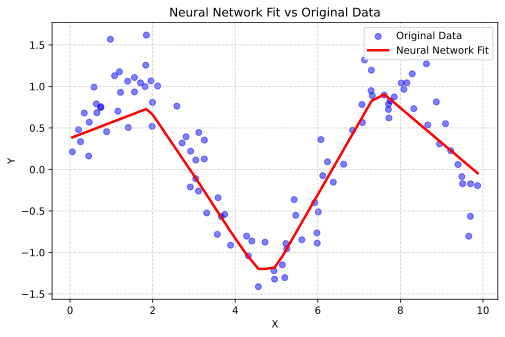

In [301]:
import numpy as np

# 1. Put the model in evaluation mode (good practice)
model.eval()

# 2. Get predictions from the trained model
# We use torch.no_grad() because we don't need to calculate gradients for plotting
with torch.no_grad():
    predictions_normalized = model(x_t).numpy()

# 3. Un-normalize the predictions back to the original scale
# Formula: original = (normalized * standard_deviation) + mean
predictions = (predictions_normalized * y.std()) + y.mean()

# 4. Sort the x values and predictions so the line plots smoothly
# If we don't sort, the line will zig-zag wildly connecting points in random order
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# 5. Plot the results
plt.figure(figsize=(8, 5))

# Plot the original raw data as blue dots
plt.scatter(x, y, label='Original Data', color='blue', alpha=0.5)

# Plot the model's predictions as a red line
plt.plot(x_sorted, predictions_sorted, label='Neural Network Fit', color='red', linewidth=2.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network Fit vs Original Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Part E

In [302]:
epochs = 1000
losses = []  # one value per epoch

for epoch in range(epochs):

    epoch_loss = 0.0  # reset each epoch

    for xin1, yin1 in loader:
        pred = model(xin1)
        loss = loss_fn(pred, yin1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # add batch loss as a number

    epoch_loss /= len(loader)      # average over batches
    losses.append(epoch_loss)      # store ONE number per epoch

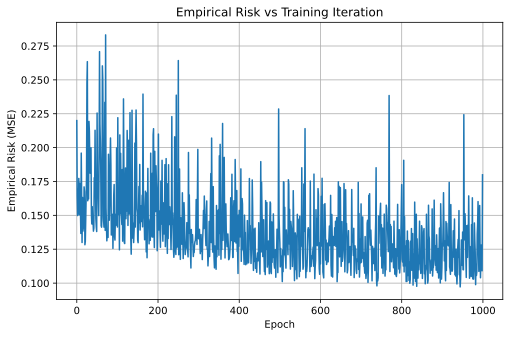

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Empirical Risk (MSE)")
plt.title("Empirical Risk vs Training Iteration")
plt.grid(True)
plt.show()

# Problem 3